In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = '..'

In [4]:
df_train = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/train.csv')
df_test = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/example_test_files/test.csv')
revealed_targets = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../optiver-trading-at-the-close/train.csv'

In [ ]:
df_train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [ ]:
indices = ['stock_id', 'date_id','time_id', 'row_id']

features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
            'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
            'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
            'imb_s1', 'imb_s2','target']

In [ ]:
def enrich_features(df):

    df_ = df.copy()

    df_['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df_['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df_[f'{a}_{b}_imb'] = df_.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')    
                    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df_[[a,b,c]].max(axis=1)
                    min_ = df_[[a,b,c]].min(axis=1)
                    mid_ = df_[[a,b,c]].sum(axis=1)-min_-max_

                    df_[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_ + 0.1)
                    features.append(f'{a}_{b}_{c}_imb2')
    
    return df_

# TRAINING = True
# if TRAINING:
#     df_train = pd.read_csv(f'{DATA_PATH}/train.csv')
#     df_ = generate_features(df_train)
df_train_ = enrich_features(df_train)

In [ ]:
df_train_.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'imb_s1', 'imb_s2',
       'far_price_reference_price_imb', 'near_price_reference_price_imb',
       'near_price_far_price_imb', 'ask_price_reference_price_imb',
       'ask_price_far_price_imb', 'ask_price_near_price_imb',
       'bid_price_reference_price_imb', 'bid_price_far_price_imb',
       'bid_price_near_price_imb', 'bid_price_ask_price_imb',
       'wap_reference_price_imb', 'wap_far_price_imb', 'wap_near_price_imb',
       'wap_ask_price_imb', 'wap_bid_price_imb',
       'near_price_far_price_reference_price_imb2',
       'ask_price_far_price_reference_price_imb2',
       'ask_price_near_price_reference_price_imb2',
       'ask_price_near_price_far_price_imb2',
       'bid_price_far_price_reference_price_imb2',
  

<Axes: >

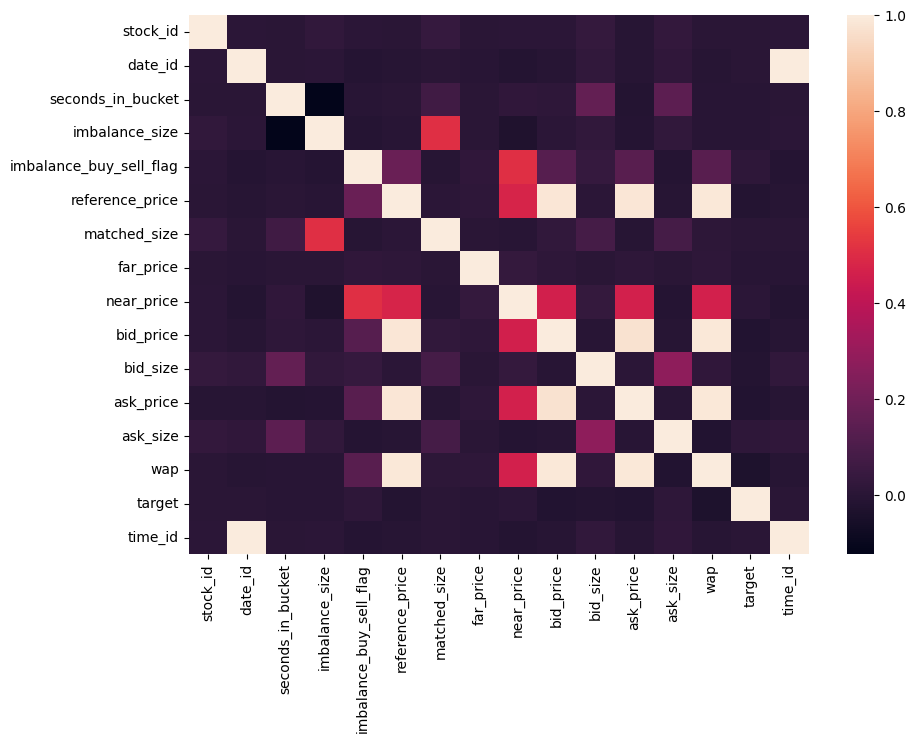

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_train.iloc[:, :-1].corr())


In [ ]:
df_train.iloc[:, :-1].corr().target.sort_values()

wap                       -0.035165
bid_price                 -0.022326
ask_price                 -0.021674
bid_size                  -0.018000
reference_price           -0.017394
seconds_in_bucket         -0.002203
far_price                 -0.001804
imbalance_size            -0.001190
stock_id                   0.000130
matched_size               0.000197
time_id                    0.000889
date_id                    0.000893
near_price                 0.006045
ask_size                   0.014936
imbalance_buy_sell_flag    0.015102
target                     1.000000
Name: target, dtype: float64

<Axes: >

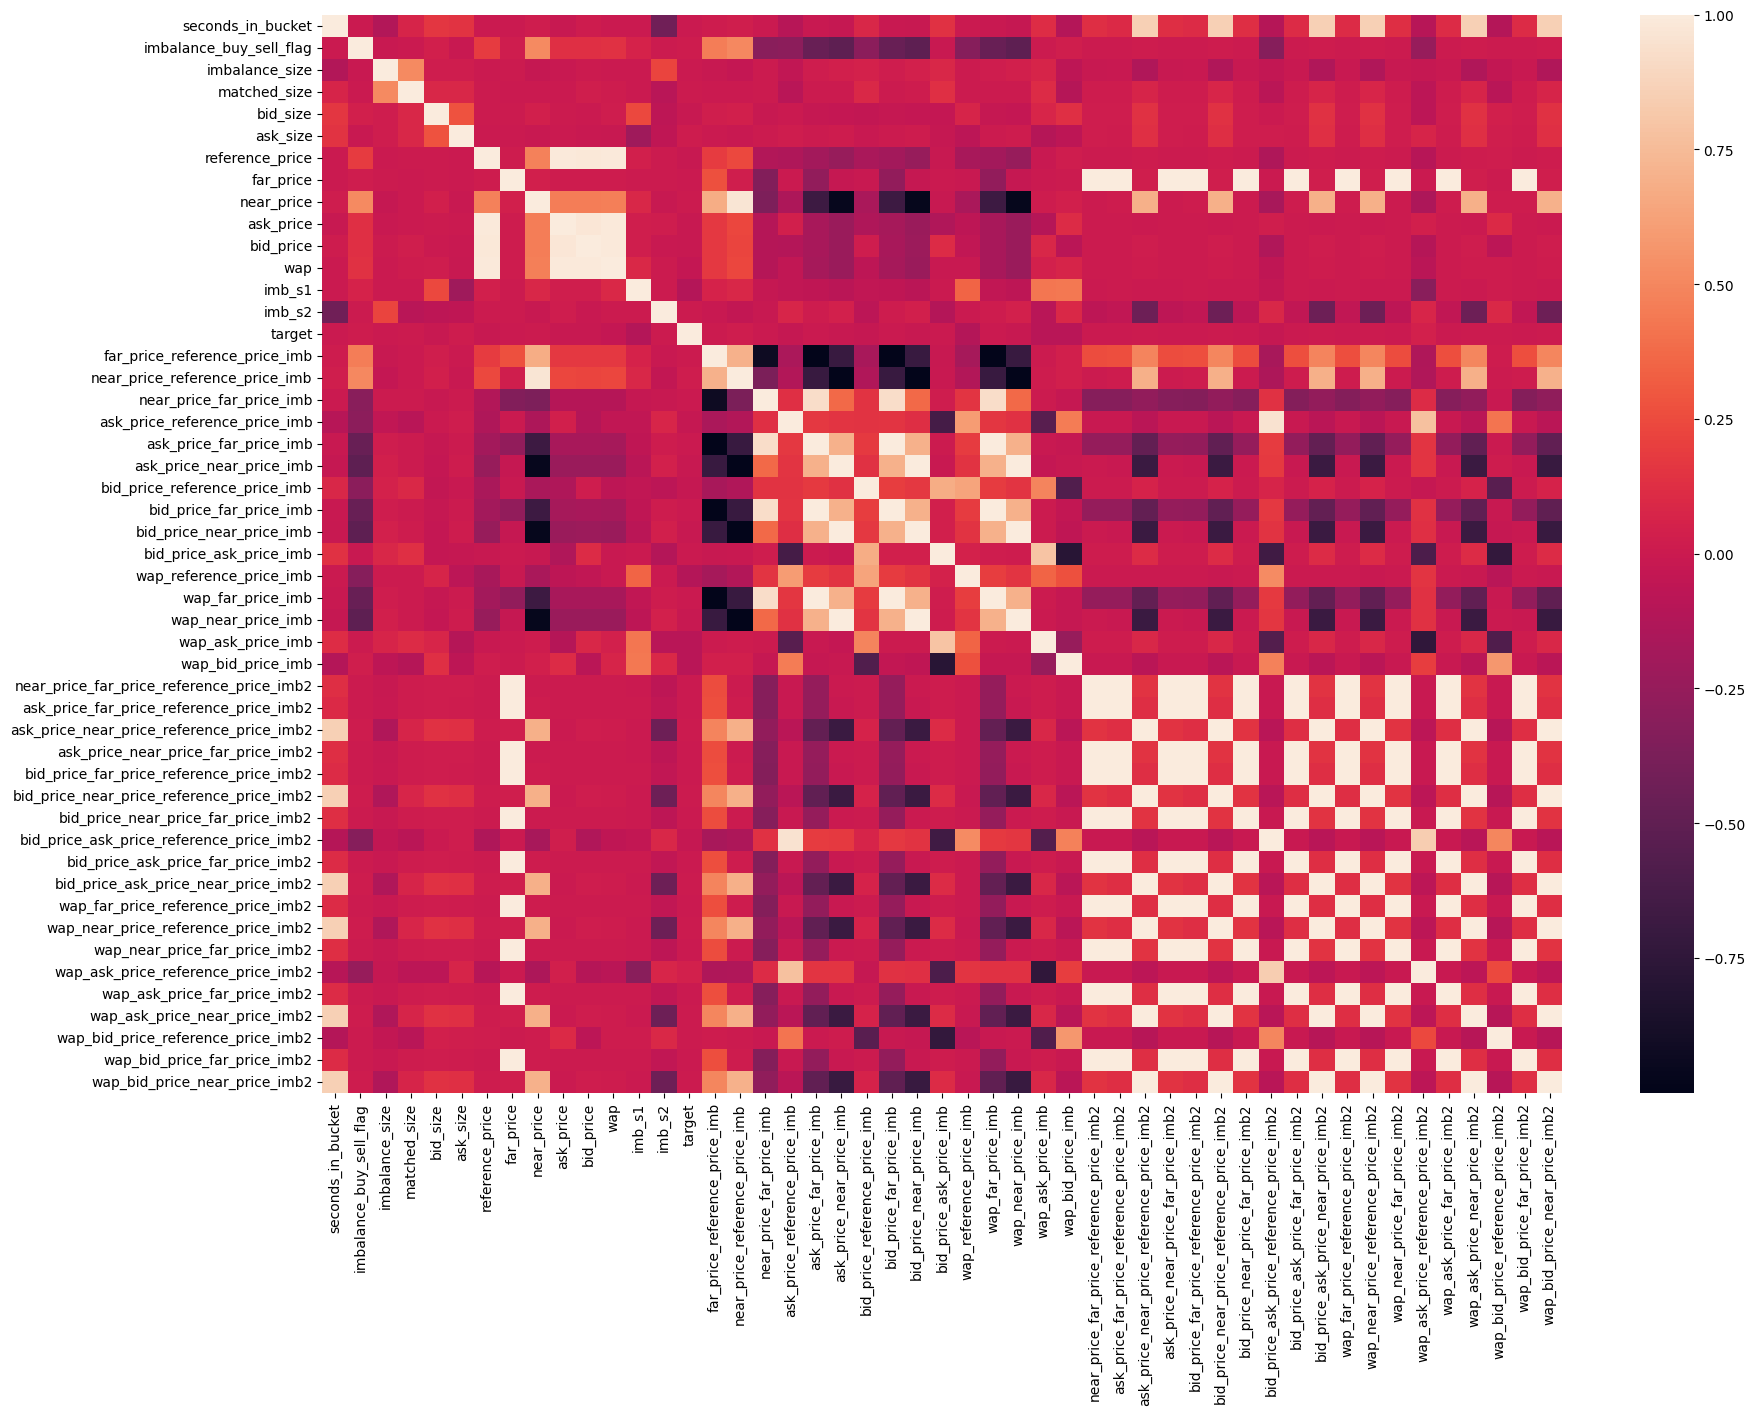

In [ ]:
plt.figure(figsize=(20,14))
sns.heatmap(df_train_[features].iloc[:, :-1].corr())

<Axes: >

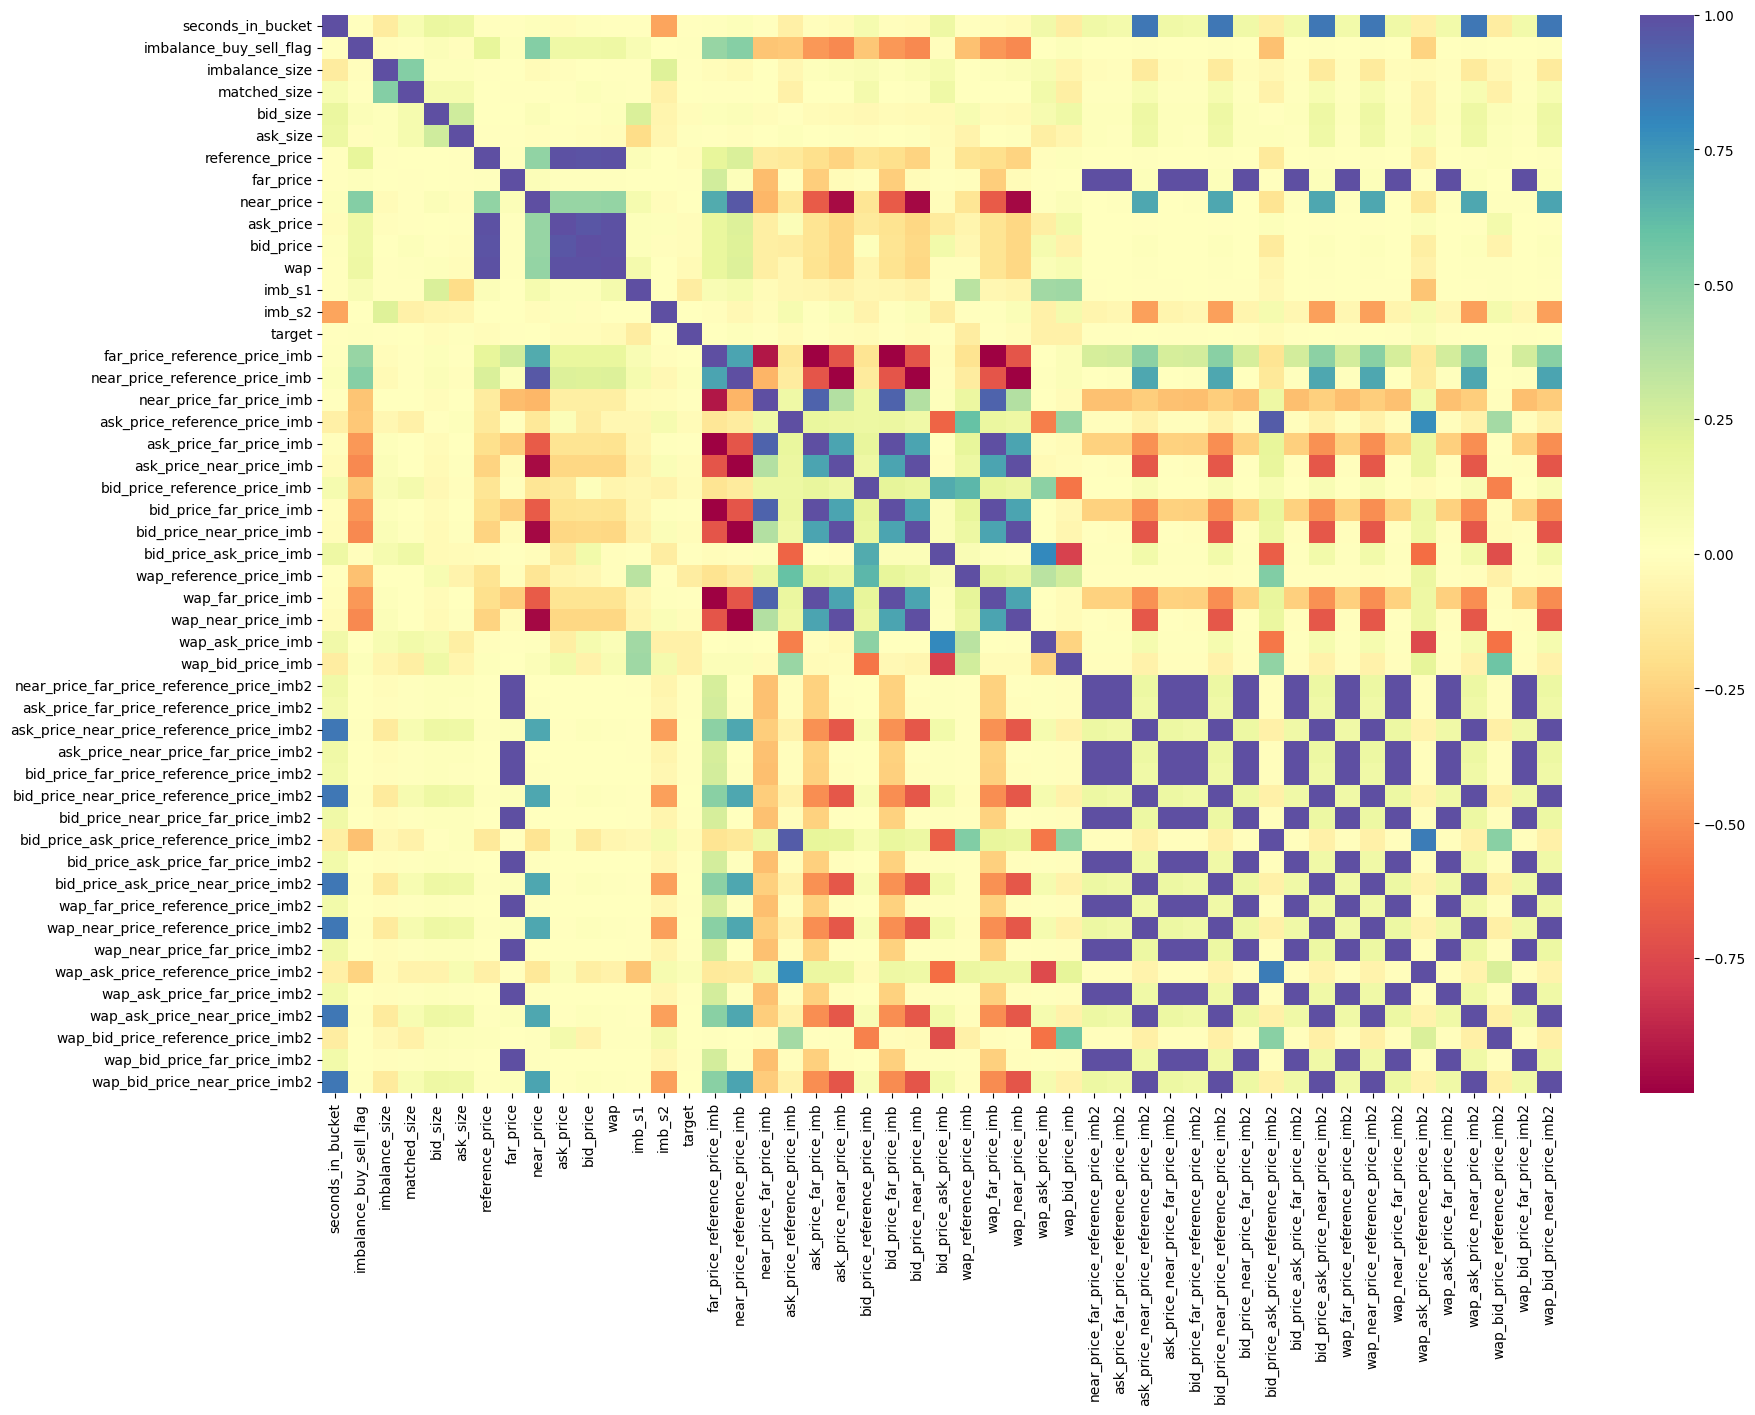

In [ ]:
plt.figure(figsize=(20,14))
sns.heatmap(df_train_[features].iloc[:, :-1].corr(), cmap="Spectral")

<Axes: title={'center': 'Stock 0 on Day 0 - How the order book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

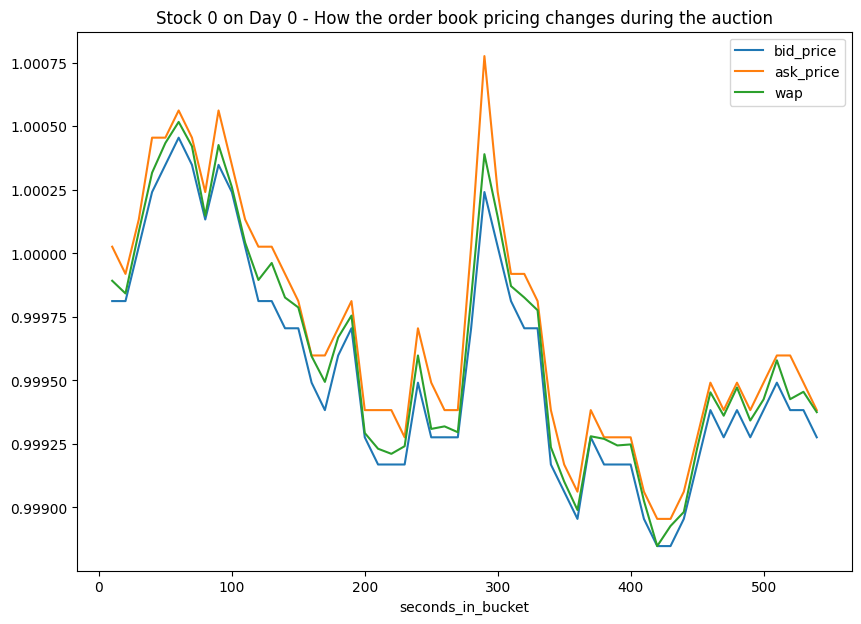

In [ ]:
(
    df_train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction',
         figsize=(10, 7))
)

<Axes: title={'center': 'Stock 0 on Day 0 - How the order book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

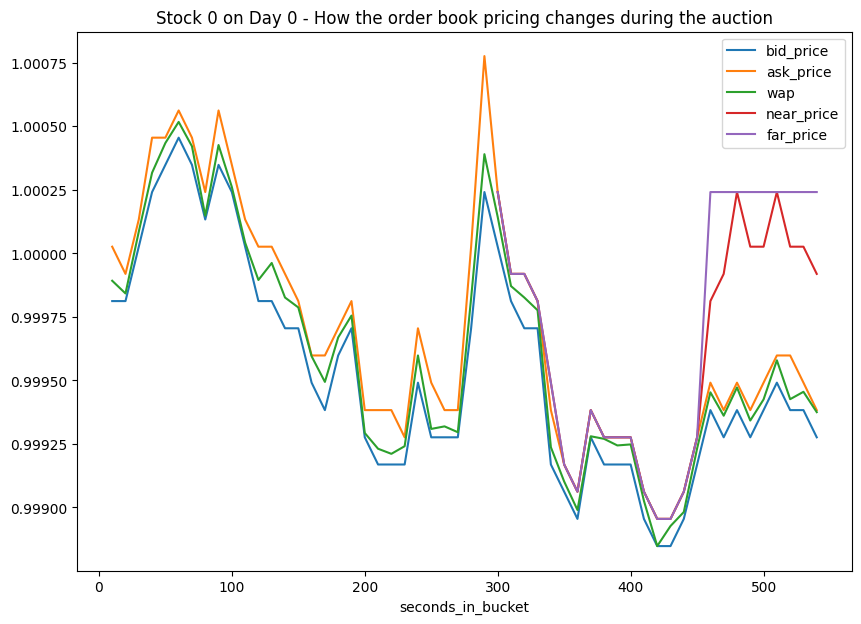

In [ ]:
(
    df_train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap', 'near_price', 'far_price']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction',
         figsize=(10, 7))
)

In [ ]:
df_train_.iloc[:, :-1].corr().target.sort_values()

imb_s1                                      -0.114617
wap_reference_price_imb                     -0.112435
wap_ask_price_imb                           -0.089753
wap_bid_price_imb                           -0.087378
wap                                         -0.035165
bid_price_reference_price_imb               -0.025835
bid_price_ask_price_reference_price_imb2    -0.024434
ask_price_reference_price_imb               -0.023632
bid_price                                   -0.022326
wap_near_price_imb                          -0.021925
ask_price                                   -0.021674
ask_price_near_price_imb                    -0.019841
bid_price_near_price_imb                    -0.019584
bid_size                                    -0.018000
reference_price                             -0.017394
wap_far_price_imb                           -0.007350
ask_price_far_price_imb                     -0.006279
bid_price_far_price_imb                     -0.006180
bid_price_ask_price_imb     

<Axes: >

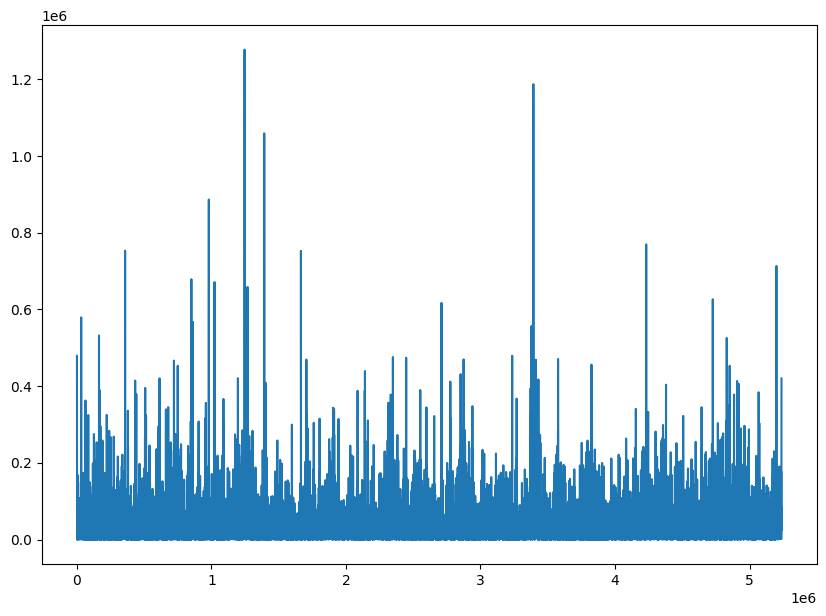

In [ ]:
df_train[(df_train["stock_id"]==3)]['ask_size'].plot(figsize=(10, 7))

<Axes: xlabel='ask_size'>

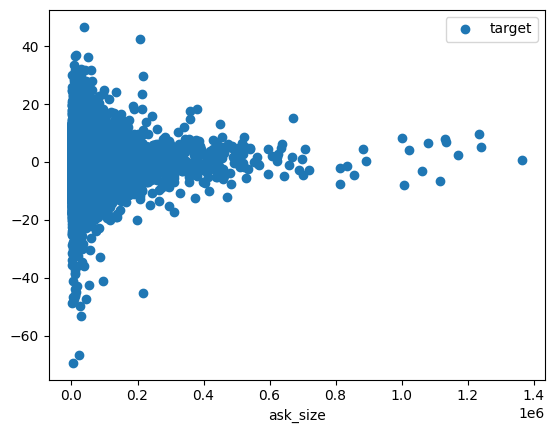

In [ ]:
first_stock = df_train_[(df_train_["stock_id"]==0)]
first_stock.plot(x='ask_size', y='target', style='o')

<Axes: xlabel='ask_size'>

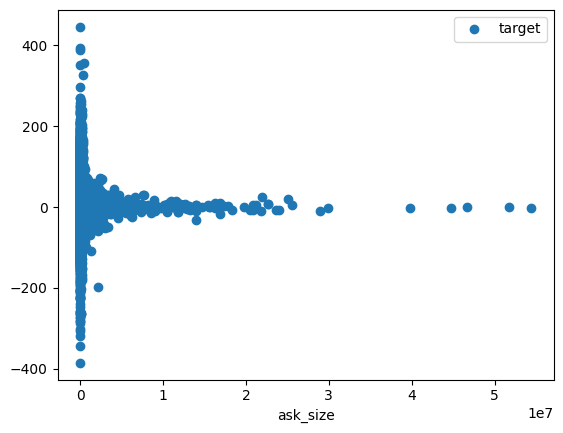

In [ ]:
df_train_[~((df_train_["stock_id"]==0) & (df_train_["date_id"] ==0))].plot(x='ask_size', y='target', style='o')

<Axes: xlabel='imbalance_buy_sell_flag'>

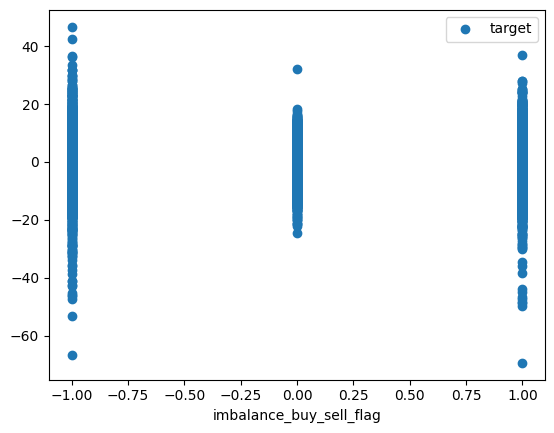

In [ ]:
first_stock.plot(x='imbalance_buy_sell_flag', y='target', style='o')

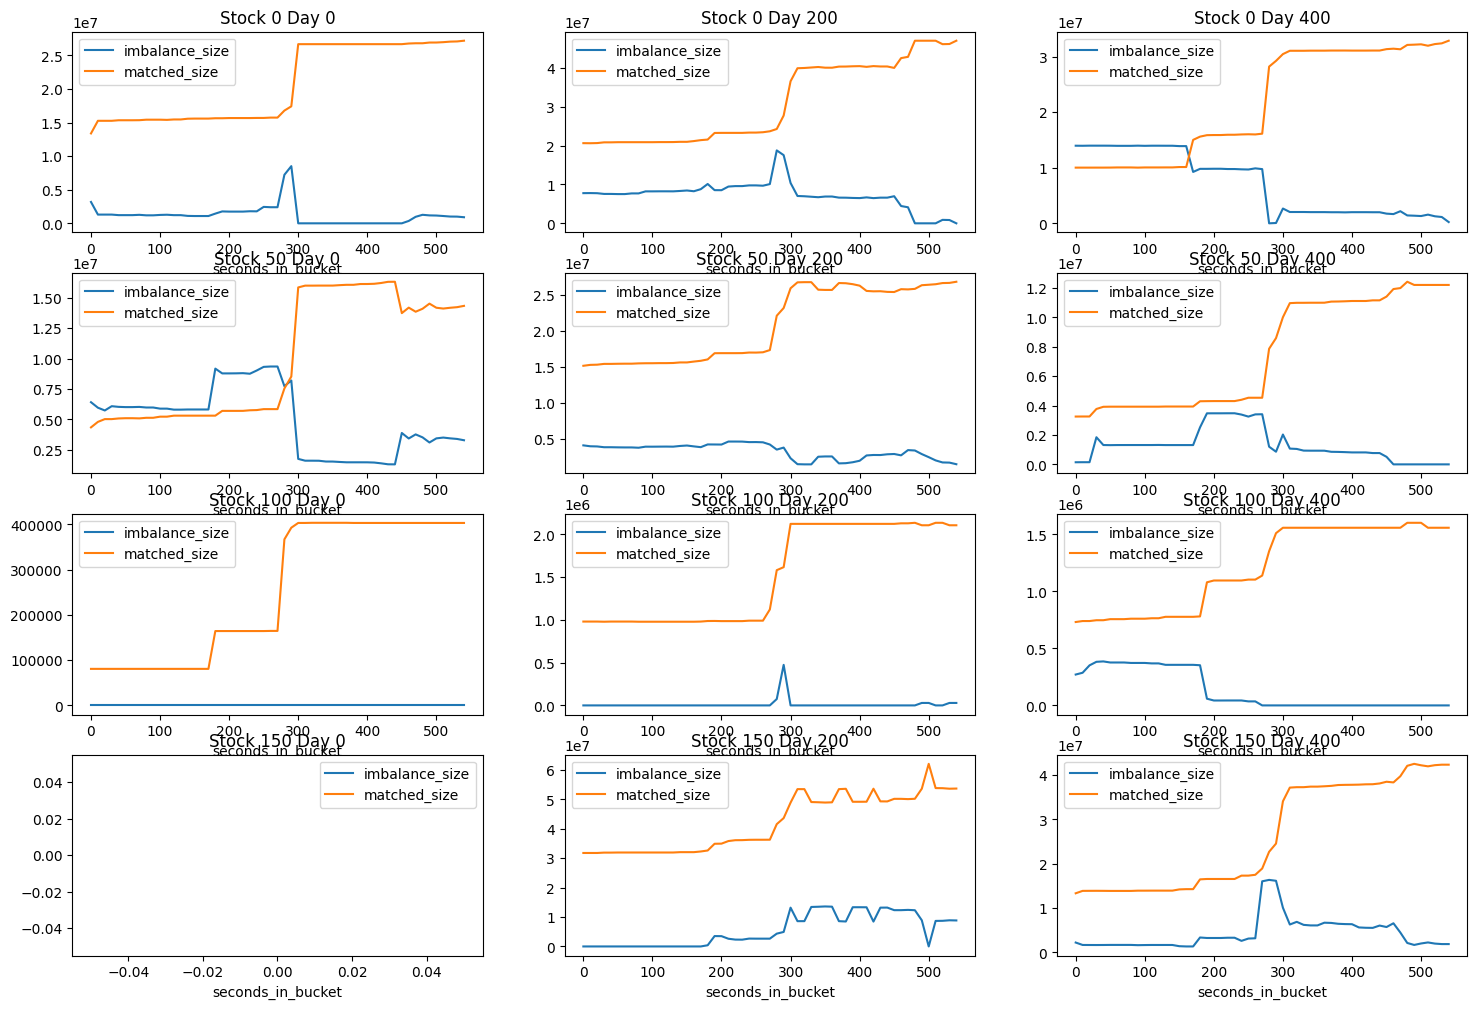

In [ ]:
# plt.figure(figsize=(20,14))
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
# fig.canvas.set_window_title('How the auction sizing changes during the auction period')

for stock in [0, 50, 100, 150]:
    for day in [0, 200, 400]:
        axes[int(stock/50),int(day/200)].title.set_size(1)
        (            
            df_train
            .query(f"stock_id =={stock} & date_id =={day}")
            [['seconds_in_bucket','imbalance_size','matched_size']]
            .set_index('seconds_in_bucket')
            .plot(title=f"Stock {stock} Day {day}", ax=axes[int(stock/50),int(day/200)])
        )

In [ ]:
simple_mapping = {
    1: 0.1,
    0: 0,
    -1: -0.1
}

df_train['baseline_prediction'] = 0
df_train['simple_prediction'] = df_train['imbalance_buy_sell_flag'].map(simple_mapping)

In [ ]:
baseline_mae = (df_train['baseline_prediction'] - df_train['target']).abs().mean()
simple_prediction_mae = (df_train['simple_prediction'] - df_train['target']).abs().mean()

print(baseline_mae, simple_prediction_mae)
print('MAE improvement in basis points: ', (baseline_mae-simple_prediction_mae))

6.40777074811524 6.407056596608261
MAE improvement in basis points:  0.000714151506978844


In [ ]:
df_.iloc[:, :-1].corr().target.sort_values()

imb_s1                                      -0.114617
wap_reference_price_imb                     -0.112435
wap_ask_price_imb                           -0.089753
wap_bid_price_imb                           -0.087378
wap                                         -0.035165
bid_price_reference_price_imb               -0.025835
bid_price_ask_price_reference_price_imb2    -0.024434
ask_price_reference_price_imb               -0.023632
bid_price                                   -0.022326
wap_near_price_imb                          -0.021925
ask_price                                   -0.021674
ask_price_near_price_imb                    -0.019841
bid_price_near_price_imb                    -0.019584
bid_size                                    -0.018000
reference_price                             -0.017394
wap_far_price_imb                           -0.007350
ask_price_far_price_imb                     -0.006279
bid_price_far_price_imb                     -0.006180
bid_price_ask_price_imb     